# Mask, Generator, Analysis
This notebook reads in images, creates the mask targets, and uses a custom generator to randomly rotate/flip the targets.

It also analyzes the model and loss output for a given run.

In [1]:
import glob
import cv2
import os
import glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

import numpy as np
import pandas as pd

from scipy.integrate import simps
from scipy import signal
from PIL import Image
import utils.make_density_map as mdm

In [2]:
def get_im_cv2(path, img_width, img_height):
    img = cv2.imread(path)
    resized = cv2.resize(img, (img_width, img_height))#, cv2.INTER_LINEAR)
    return resized

def load_data(path, data_type, img_width, img_height):
    X, X_id, y = [], [], []
    minpix = 2                                  #minimum number of pixels for crater to count
    files = glob.glob('%s*.png'%path)
    print "number of %s files are: %d"%(data_type,len(files))
    for i,fl in enumerate(files):
        flbase = os.path.basename(fl)
        img = get_im_cv2(fl,img_width,img_height)
        X.append(img)
        X_id.append(fl)
        
        csv = pd.read_csv('%s.csv'%fl.split('.png')[0])
        csv.drop( np.where(csv["Diameter (pix)"] < minpix)[0], inplace=True )
        target = mdm.make_mask(csv, img, binary=False, truncate=True)
        maxx = target.max()
        if maxx > 0:
            target /= maxx            #normalizing between 0-1
        y.append(target)
    return  X, y, X_id

def read_and_normalize_data(path, img_width, img_height, data_flag):
    if data_flag == 0:
        data_type = 'train'
    elif data_flag == 1:
        data_type = 'test'
    data, target, id = load_data(path, data_type, img_width, img_height)
    data = np.array(data).astype('float32')     #convert to numpy, convert to float
    #target = np.array(target).astype('float32')
    data = data / 255.                           #normalize
    print('%s shape:'%data_type, data.shape)
    return data, target, id

In [3]:
train_data, train_target, train_id = read_and_normalize_data('training_set/', 300, 300, 0)
test_data, test_target, test_id = read_and_normalize_data('test_set/', 300, 300, 0)

number of train files are: 90
('train shape:', (90, 300, 300, 3))
number of train files are: 26
('train shape:', (26, 300, 300, 3))


## Custom Image Generator

In [22]:
def custom_image_generator(data, target, batch_size=2):
    np.random.seed(0)
    L, W = data[0].shape[0], data[0].shape[1]
    while True:
        for i in range(0, len(data), batch_size):
            d, t = data[i:i+batch_size].copy(), target[i:i+batch_size].copy() #most efficient for memory?
            
            #horizontal/vertical flips
            for j in np.where(np.random.randint(0,2,batch_size)==1)[0]:
                d[j], t[j] = np.fliplr(d[j]), np.fliplr(t[j])                 #left/right 
            for j in np.where(np.random.randint(0,2,batch_size)==1)[0]:
                d[j], t[j] = np.flipud(d[j]), np.flipud(t[j])                 #up/down
                
            #random up/down and left/right pixel shifts
            npix = 10
            h = np.random.randint(-npix,npix+1,batch_size)                         #horizontal shift
            v = np.random.randint(-npix,npix+1,batch_size)                         #vertical shift
            r = np.random.randint(0,4,batch_size)                                  #random 90 degree rot
            for j in range(batch_size):
                d[j] = np.pad(d[j], ((npix,npix),(npix,npix),(0,0)), mode='constant')[npix+h[j]:L+h[j]+npix,npix+v[j]:W+v[j]+npix,:] 
                t[j] = np.pad(t[j], (npix,), mode='constant')[npix+h[j]:L+h[j]+npix,npix+v[j]:W+v[j]+npix]
                d[j], t[j] = np.rot90(d[j],r[j]), np.rot90(t[j],r[j])
            yield (d, t)

In [23]:
#Manipulate the first n_images in the training set
batch_size = 10
images = []
for batch in custom_image_generator(train_data,train_target,batch_size):
    images.append(batch)
    break 

In [ ]:
i=33      #i < n_images

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[6, 6])

ax1.imshow(train_data[i], origin='upper', cmap="Greys_r")
ax1.set_title('Original Image')

ax2.imshow(images[0][0][i], origin='upper', cmap="inferno")
ax2.set_title('Modified Image')


ax3.imshow(train_target[0][:][None], origin='upper', cmap="Greys_r")
#ax3.imshow(train_target[i].reshape(300,300), origin='upper', cmap="Greys_r")
ax3.set_title('Original Mask')

ax4.imshow(images[0][1][i].reshape(300,300), origin='upper', cmap="inferno")
ax4.set_title('Modified Mask')

#plt.savefig('sample.png')

## Testing that MAE/MSE is doing the right thing for both 2D and 3D

In [7]:
a=0
b = np.roll(train_target,1,axis=0)  #shift array by 1
for i in range(len(train_target)-1):
   summ = np.sum((train_target[i] - b[i+1])**2)
   a += summ
print a  #should get 0

#print np.sum((train_target[0:-1] - b[1:])**2), np.sum((train_target - b)**2)

0.0


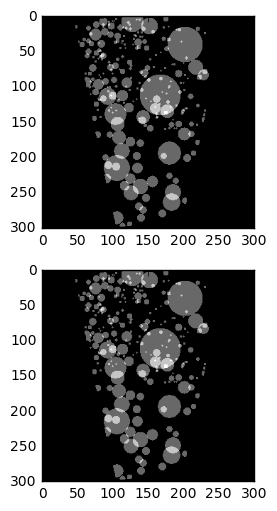

In [7]:
f, (ax1, ax2) = plt.subplots(2, figsize=[6, 6])
ax1.imshow(train_target[86].reshape(300,300), origin='upper', cmap="Greys_r")
ax2.imshow(b[87].reshape(300,300), origin='upper', cmap="Greys_r")

## Load model and evaluate its performance

In [4]:
from keras.models import load_model

Using TensorFlow backend.


In [5]:
model = load_model('models/FCNforkskip_norm_lmbda0.0e+00.h5')
#model.summary()

In [6]:
n=4
target = model.predict(test_data[0:n].astype('float32'))

In [7]:
err = np.sum((test_target[0:n] - target)**2) / (n*300*300)
err

0.01958960367836321

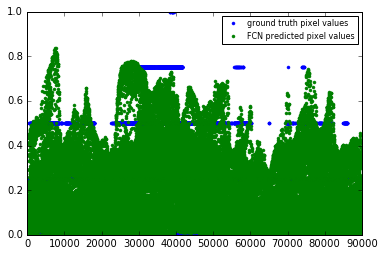

In [13]:
i=2
plt.plot(test_target[i].reshape(300*300,1), '.', label='ground truth pixel values')
plt.plot(target[i].reshape(300*300,1), '.', label='FCN predicted pixel values')
plt.legend(fontsize=8, numpoints=1)

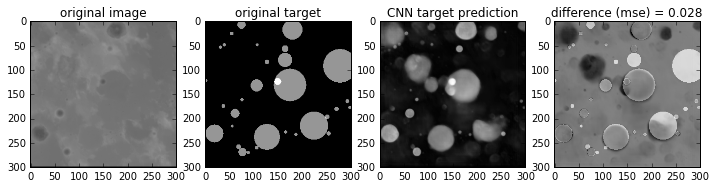

In [14]:
i=3

f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=[12, 8])
ax1.imshow(test_data[i], origin='upper', cmap="Greys_r")
ax2.imshow(test_target[i], origin='upper', cmap="Greys_r")
ax3.imshow(target[i], origin='upper', cmap="Greys_r")
ax4.imshow(test_target[i] - target[i], origin='upper', cmap="Greys_r")
ax1.set_title('original image')
ax2.set_title('original target')
ax3.set_title('CNN target prediction')
diff = np.sum((test_target[i] - target[i])**2)/(300*300)
ax4.set_title('difference (mse) = %.3f'%diff)
plt.savefig('output_dir/FCNskip_%d.png'%i)

## Plot loss vs. epoch

In [ ]:
filename = 'output_dir/FCNforkskip_norm.txt'
#filename = 'models/good_models/FCNforkskip_imggen_lmbda0.0e+00.txt'

epoch_score, N_models = [], 0
lines = open(filename, 'r').readlines()
for line in lines:
    if "val_loss:" in line:
        epoch_score.append(float(line.split('val_loss:')[1]))
    elif "Test Score is" in line:
        N_models += 1
        test_score, n_epochs = float(line.split('Test Score is')[1]), len(epoch_score)
        p = plt.plot(np.arange(n_epochs)+1, epoch_score, label='model %d'%N_models)
        plt.plot(n_epochs, test_score, 'o', color=p[0].get_color(), mew=0, label='test score, model %d'%N_models)
        plt.legend(fontsize=8, numpoints=1)
        epoch_score = []

plt.plot(np.arange(len(epoch_score))+1, epoch_score)
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.yscale('log')